<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

# Pyosim in the cloud
## with [pyomeca](https://github.com/pyomeca/pyomeca)
Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Raw data](01.01-raw-data.ipynb) | [Contents](Index.ipynb) |

# Inverse kinematics

In [1]:
from pathlib import Path

import yaml

import numpy as np
import pandas as pd
from pyosim import Conf

import altair as alt
alt.data_transformers.enable("json")

DataTransformerRegistry.enable('json')

In [2]:
MODEL = "wu"
DATA = '2_inverse_dynamic'
EXT = 'sto'

In [3]:
aws_conf = yaml.safe_load(open("../conf.yml"))

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
participants = conf.get_participants_to_process()
conf.check_confs()

Project loaded
Configuration file loaded


sarc: checked
sarc: updated in project conf
inea: checked
inea: updated in project conf
dapo: checked
dapo: updated in project conf
laug: checked
laug: updated in project conf
mara: checked
mara: updated in project conf
mars: checked
mars: updated in project conf
yosc: checked
yosc: updated in project conf
marc: checked
marc: updated in project conf
benl: checked
benl: updated in project conf
davo: checked
davo: updated in project conf
marb: checked
marb: updated in project conf
gatb: checked
gatb: updated in project conf
yoap: checked
yoap: updated in project conf
romm: checked
romm: updated in project conf




In [7]:
from pyomeca import Analogs3d

ifile = Path(f"/home/romain/Downloads/irsst/romm/{DATA}/wu_RomMH18H2_1.{EXT}")
data_path = conf.project_path / 'romm' / DATA

mot = Analogs3d.from_sto(ifile).time_normalization()

In [9]:
d = []
for ifile in data_path.glob(f"*.{EXT}"):
    f = ifile.stem.replace(f"{MODEL}_", "")

    # exclude static
    if f[-2:] != "d0":

        meta = {
            "filename": ifile.stem,
            "participant": f[:4].lower(),
            "sex": f[4],
            "height": f[-3],
            "weight": f[5:].split("H")[0],
            "trial": f[-1],
        }

        d.append(
            Analogs3d.from_sto(ifile)
            .time_normalization()
            .update_misc(meta)
            .to_dataframe(add_metadata=["misc"])
        )
d = pd.concat(d).reset_index()

d.head()

,index,thorax_tilt_moment,thorax_list_moment,thorax_rotation_moment,thorax_tx_force,thorax_ty_force,thorax_tz_force,box_rotX_moment,box_rotY_moment,box_rotZ_moment,...,elbow_flexion_moment,pro_sup_moment,hand_r_Add_moment,hand_r_Flex_moment,filename,participant,sex,height,weight,trial
0,0,98.890252,8.964408,-12.919561,-0.736867,441.645679,0.094068,0.156120,-0.000698,0.085033,...,8.535288,0.022536,1.788185,-1.098872,wu_RomMH6H2_3,romm,H,2,6,3
1,1,132.903568,2.773249,-19.342545,-72.836205,484.249802,-6.046936,0.155010,-0.003475,0.085088,...,6.265429,0.410677,0.256336,-2.444368,wu_RomMH6H2_3,romm,H,2,6,3
2,2,146.450083,0.906202,-20.651896,-102.343848,499.510369,-8.758813,0.154993,-0.013201,0.087575,...,7.915953,0.221712,1.336238,-2.066701,wu_RomMH6H2_3,romm,H,2,6,3
3,3,159.036009,5.647981,-15.597611,-122.143892,511.753161,-6.336030,0.156242,-0.013452,0.088404,...,9.164473,-0.618985,2.341160,-0.749182,wu_RomMH6H2_3,romm,H,2,6,3
4,4,166.954441,19.730199,-11.408188,-136.600116,530.357075,16.769466,0.157778,0.004786,0.084643,...,9.273151,-0.783732,2.498038,-0.490563,wu_RomMH6H2_3,romm,H,2,6,3


In [10]:
d_wide = d.melt(id_vars=["index", "filename", "participant", "sex", "height", "weight", "trial"])
d_wide.head()

,index,filename,participant,sex,height,weight,trial,variable,value
0,0,wu_RomMH6H2_3,romm,H,2,6,3,thorax_tilt_moment,98.890252
1,1,wu_RomMH6H2_3,romm,H,2,6,3,thorax_tilt_moment,132.903568
2,2,wu_RomMH6H2_3,romm,H,2,6,3,thorax_tilt_moment,146.450083
3,3,wu_RomMH6H2_3,romm,H,2,6,3,thorax_tilt_moment,159.036009
4,4,wu_RomMH6H2_3,romm,H,2,6,3,thorax_tilt_moment,166.954441


In [13]:
d_wide.variable.unique()

array(['thorax_tilt_moment', 'thorax_list_moment',
       'thorax_rotation_moment', 'thorax_tx_force', 'thorax_ty_force',
       'thorax_tz_force', 'box_rotX_moment', 'box_rotY_moment',
       'box_rotZ_moment', 'box_transX_force', 'box_transY_force',
       'box_transZ_force', 'sternoclavicular_r1_moment',
       'sternoclavicular_r2_moment', 'sternoclavicular_r3_moment',
       'Acromioclavicular_r1_moment', 'Acromioclavicular_r2_moment',
       'Acromioclavicular_r3_moment', 'shoulder_plane_moment',
       'shoulder_ele_moment', 'shoulder_rotation_moment',
       'elbow_flexion_moment', 'pro_sup_moment', 'hand_r_Add_moment',
       'hand_r_Flex_moment'], dtype=object)

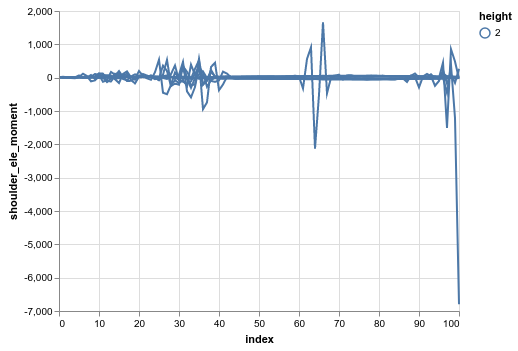

In [14]:
alt.Chart(d).mark_line().encode(
    x="index", y="shoulder_ele_moment", detail="filename", color="height"
)

In [6]:
iparticipant

'romm'

In [7]:
for iparticipant in participants:
    data_path = conf.project_path / iparticipant / "1_inverse_kinematic"
    for ifile in data_path.glob("*"):
        ifile.unlink()
        print(ifile)
#         if ifile.stem[-3] != "2" and f[-2:] != "d0":
#             ifile.unlink()
#             print(ifile)
#         else:
#             print("safe")

/home/romain/Downloads/irsst/sarc/1_inverse_kinematic/wu_SarCF12H5_2.mot
/home/romain/Downloads/irsst/sarc/1_inverse_kinematic/wu_SarCF12H6_2.mot
/home/romain/Downloads/irsst/sarc/1_inverse_kinematic/wu_IRSST_SarCd0.mot
/home/romain/Downloads/irsst/sarc/1_inverse_kinematic/wu_SarCF6H6_1.mot
/home/romain/Downloads/irsst/sarc/1_inverse_kinematic/wu_SarCF6H5_2_ik_marker_errors.sto
/home/romain/Downloads/irsst/sarc/1_inverse_kinematic/wu_SarCF12H1_1_ik_marker_errors.sto
/home/romain/Downloads/irsst/sarc/1_inverse_kinematic/wu_SarCF12H2_2.mot
/home/romain/Downloads/irsst/sarc/1_inverse_kinematic/wu_SarCF6H3_2_ik_marker_errors.sto
/home/romain/Downloads/irsst/sarc/1_inverse_kinematic/wu_SarCF6H1_3_ik_marker_errors.sto
/home/romain/Downloads/irsst/sarc/1_inverse_kinematic/wu_SarCF12H6_2_ik_marker_errors.sto
/home/romain/Downloads/irsst/sarc/1_inverse_kinematic/wu_SarCF6H1_3.mot
/home/romain/Downloads/irsst/sarc/1_inverse_kinematic/wu_SarCF6H5_2.mot
/home/romain/Downloads/irsst/sarc/1_inverse_

<!--NAVIGATION-->
< [Raw data](01.01-raw-data.ipynb) | [Contents](Index.ipynb) |